In [1]:
import matplotlib.pyplot as plt
import numpy as np

import mpl_style
plt.style.use(mpl_style.style)

from microlensing.IPM.ipm import IPM
from microlensing.CCF.ccf import CCF
from microlensing.NCC.ncc import NCC

# Creating a magnification map

In [2]:
ipm = IPM(verbose=1, kappa_tot=0.4, shear=0.4, smooth_fraction=0.5, 
          rectangular=True, approx=True, half_length_y1=25, half_length_y2=25,
          mass_function='kroupa', m_lower=0.08, m_upper=100,
          num_pixels_y1=5000, num_pixels_y2=5000,
          write_stars=True)

In [3]:
ipm.random_seed = 0 # setting to 0 will cause object to generate a random seed of its own

In [4]:
ipm.run()

Generating star field...
Done generating star field. Elapsed time: 0 seconds.

Creating children and sorting stars...
Done creating children and sorting stars. Elapsed time: 0.079 seconds.

Calculating multipole and local coefficients...
Done calculating multipole and local coefficients. Elapsed time: 0.081 seconds.

Shooting cells...
100 %
Done shooting cells. Elapsed time: 2.422 seconds.



In [5]:
ipm.num_stars

17313

In [6]:
fig, ax = plt.subplots()
ipm.plot(ax)
plt.show()

In [7]:
ipm.save() # save stars to disk to use for finding caustics

Done writing parameter info to file ./ipm_parameter_info.txt
Done writing star info to file ./ipm_stars.bin


# Locating critical curves and caustics

In [8]:
ccf = CCF(verbose=1, kappa_tot=ipm.kappa_tot, shear=ipm.shear, num_phi=200, 
          starfile=f'{ipm.outfile_prefix}ipm_stars.bin',
          outfile_prefix=ipm.outfile_prefix,
          write_caustics=True)

In [9]:
ccf.run()

Creating children and sorting stars...
Done creating children and sorting stars. Elapsed time: 0.077 seconds.

Calculating multipole and local coefficients...
Done calculating multipole and local coefficients. Elapsed time: 0.107 seconds.

Finding initial roots...
[==================================================] 100 %
Done finding initial roots. Elapsed time: 3.597 seconds.
Maximum error in 1/mu: 7.71493e-08

Finding critical curve positions...
[==================================================] 100 %
Done finding critical curve positions. Elapsed time: 70.928 seconds.
Maximum error in 1/mu: 1.00578e-07



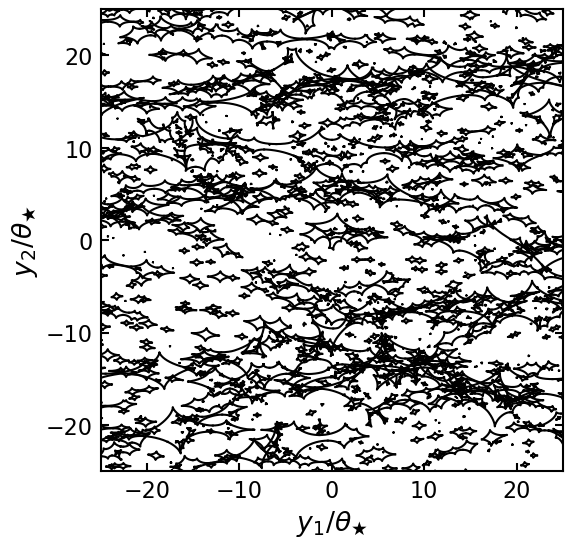

In [10]:
fig, ax = plt.subplots()
ccf.plot_caustics(ax, color='black')
ax.set_xlim([-ipm.half_length[0], ipm.half_length[0]])
ax.set_ylim([-ipm.half_length[1], ipm.half_length[1]])
ax.set_aspect(ipm.half_length[0] / ipm.half_length[1])
plt.show()

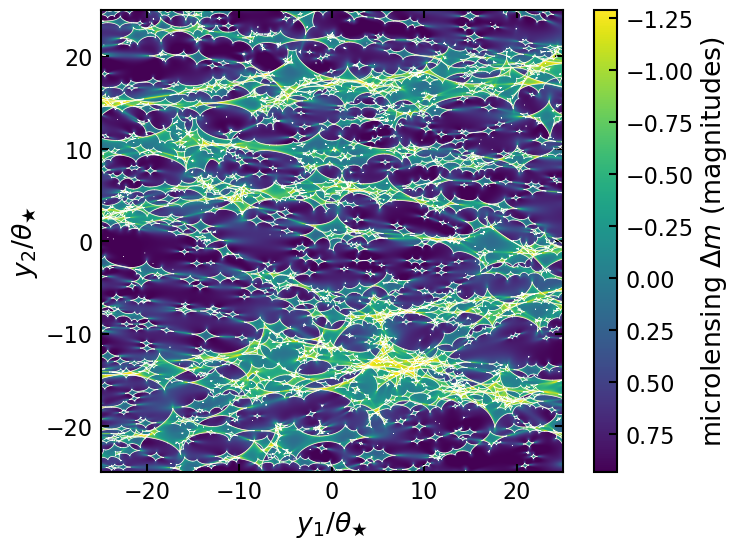

In [11]:
fig, ax = plt.subplots()
ipm.plot(ax)
ccf.plot_caustics(ax, c='white', lw=0.5)
ax.set_xlim([-ipm.half_length[0], ipm.half_length[0]])
ax.set_ylim([-ipm.half_length[1], ipm.half_length[1]])
ax.set_aspect(ipm.half_length[0] / ipm.half_length[1])
plt.show()

In [12]:
fig, ax = plt.subplots()
ccf.plot_critical_curves(ax)
ax.set_xlim([-ipm.half_length[0] / np.abs(1 - ipm.kappa_tot + ipm.shear), 
             ipm.half_length[0] / np.abs(1 - ipm.kappa_tot + ipm.shear)])
ax.set_ylim([-ipm.half_length[1] / np.abs(1 - ipm.kappa_tot - ipm.shear), 
             ipm.half_length[1] / np.abs(1 - ipm.kappa_tot - ipm.shear)])
ax.set_aspect(ipm.half_length[0] / ipm.half_length[1])
plt.show()

In [13]:
ccf.save() # save caustics to disk for calculating number of caustic crossings

Done writing parameter info to file ./ccf_parameter_info.txt
Done writing caustic positions to file ./ccf_caustics.bin


# Calculate number of caustic crossings

In [14]:
ncc = NCC(verbose=1, over_sample=0, infile_prefix=ccf.outfile_prefix,
          center_y1=ipm.center_y1, center_y2=ipm.center_y2,
          half_length_y1=ipm.half_length_y1, half_length_y2=ipm.half_length_y2,
          num_pixels_y1=ipm.num_pixels_y1, num_pixels_y2=ipm.num_pixels_y2)

In [15]:
ncc.run()

Reading in caustics...
Done reading in caustics. Elapsed time: 0.974 seconds.

Calculating number of caustic crossings...
100 %
Done calculating number of caustic crossings. Elapsed time: 0.065 seconds.

Downsampling number of caustic crossings...
Done downsampling number of caustic crossings. Elapsed time: 0 seconds.



In [16]:
fig, ax = plt.subplots()
ncc.plot_map(ax)
plt.show()

In [17]:
fig, ax = plt.subplots()
ccf.plot_caustics(ax, color='white', linewidth=0.5)
ncc.plot_map(ax)
ax.set_xlim([-ipm.half_length[0], ipm.half_length[0]])
ax.set_ylim([-ipm.half_length[1], ipm.half_length[1]])
ax.set_aspect(ipm.half_length[0] / ipm.half_length[1])
plt.show()

# Creating lightcurves

In [18]:
from microlensing.Lightcurves import lightcurves
from microlensing.SourceProfiles import uniform_disk, gaussian

### Supernova lightcurves

In [19]:
# create an array of expanding disks up to a radius of 100 pixels
source = uniform_disk.UniformDisks(100)

positions = 100 # 100 random positions

lcs, positions = lightcurves.changing_source(ipm, source, positions, return_pos=True)

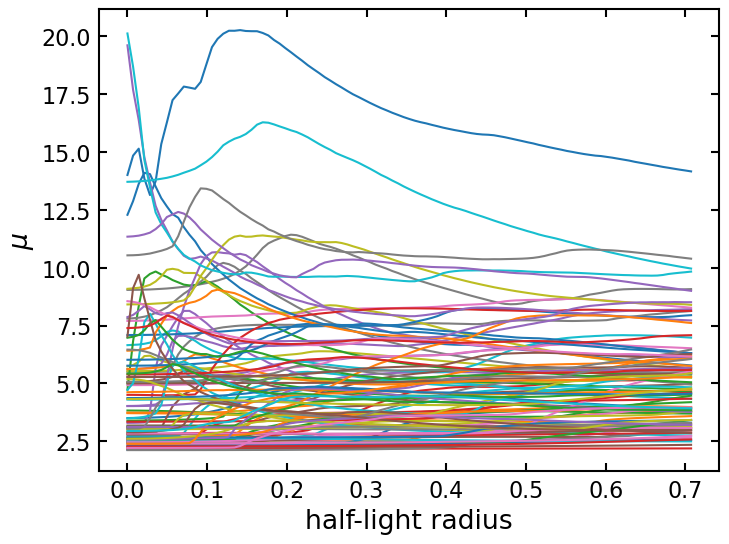

In [20]:
fig, ax = plt.subplots()

for lc in lcs:
    ax.plot(source.half_light_radii * ipm.pixel_scales[0], lc)

ax.set_xlabel('half-light radius')
ax.set_ylabel('$\\mu$')

plt.show()

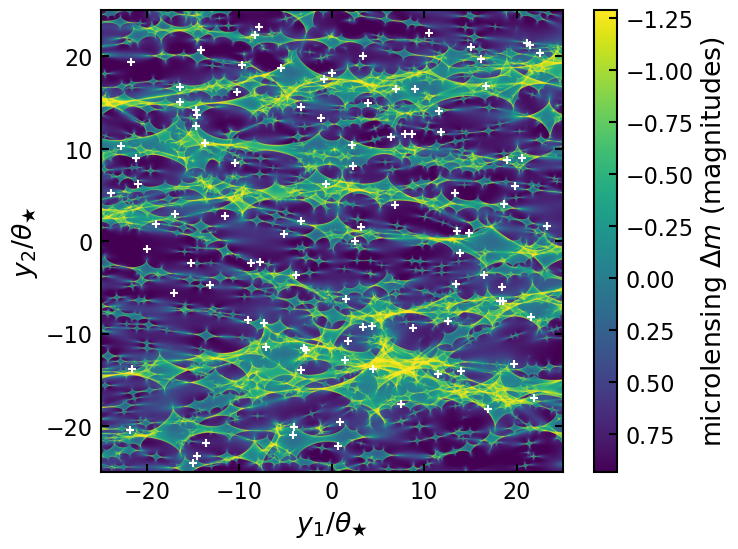

In [21]:
# plot positions on the magnification map

fig, ax = plt.subplots()

ipm.plot(ax)
ax.scatter(positions[:,0], positions[:,1], color='white', marker='+')

plt.show()

### Quasar lightcurves

In [22]:
# create a single source profile, a Gaussian with 99.9% of the flux inside a 50 pixel radius
source = gaussian.Gaussian(50)

# a source track that starts at (-10,-7) and travels 20 units right and 9 units up
positions = np.array([-10,-7]) + np.linspace(0,1,1000)[:,None] * [20,9]

lc = lightcurves.constant_source(ipm, source, positions)

In [23]:
fig, ax = plt.subplots()

distance = np.linalg.norm(positions - positions[0], axis=1)
ax.plot(distance, lc)

ax.set_xlabel('distance')
ax.set_ylabel('$\\mu$')

plt.show()

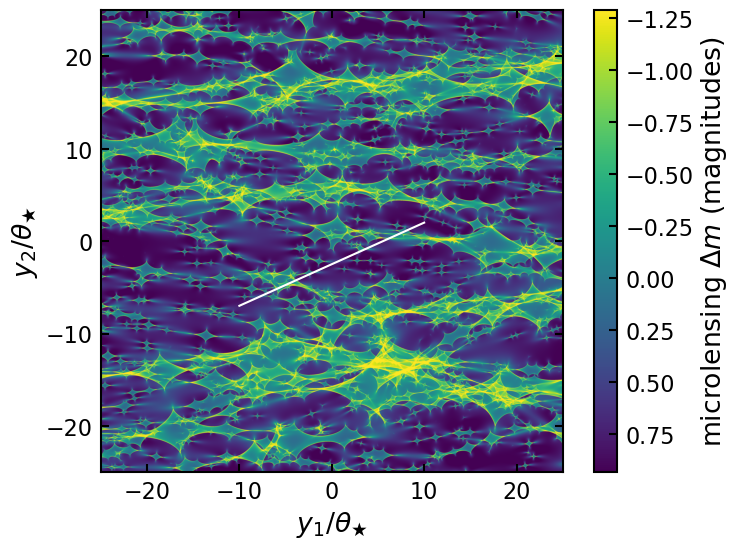

In [24]:
fig, ax = plt.subplots()
ipm.plot(ax)
ax.plot(*positions.T, color='white')
plt.show()

In [25]:
# two different tracks for a uniform disk profile instead of a Gaussian
source = uniform_disk.UniformDisk(50)

positions = np.array([np.array([-10,-7]) + np.linspace(0,1,1000)[:,None] * [6,9],
                      np.array([5,3]) + np.linspace(0,1,1000)[:,None] * [-13,12]])

lcs = lightcurves.constant_source(ipm, source, positions)

In [26]:
fig, ax = plt.subplots()

for p, lc in zip(positions, lcs):
    dists = np.linalg.norm(p - p[0], axis=1)
    ax.plot(dists, lc)

ax.set_xlabel('distance')
ax.set_ylabel('$\\mu$')

plt.show()

In [27]:
fig, ax = plt.subplots()
ipm.plot(ax)
ax.plot(*positions.T)
plt.show()